# Sedov Blast: CouchDG

This notebook describes the "Sedov" blast setup computed with the DG prototype [couchdg](https://github.com/jmark/couchdg).

Setup characteristics:

| term                 | symbol    | value               |
|:-------------------- |:---------:|:-------------------:|
| governing equations  |  --       | compressible Euler  |
| equation of state    |  --       |ideal gas (adiabatic)|
| ambient density      | $\rho_0$  | $1.0$               |
| ambient pressure     | $p_0$     | $10^{-5} \approx 0$ |
| adiabatic const.     | $\gamma$  | $1.4$               |
| initial blast energy | $E_0$     | $1.1086774177$      |
| node type            |   --      | gauss-lobatto       |
| polynomial order     | $N_p$     |  3                  |
| number of elements   | $N_e$     | 192 x 192           |
| "FV-equiv." resolution | $N_r$   | 768 x 768           |

## Density and pressure heat maps

In [93]:
import sys
import os
home = os.environ['HOME']
sys.path.append(home + '/projects/turbubox/tools/lib')

import numpy as np
import pandas as pd
import glob
import couchdg
import cubicle

import matplotlib
matplotlib.rcParams.update({'font.size': 9})

import matplotlib.pyplot as plt
%matplotlib inline

gamma = 1.4

In [94]:
def lmaxF(dens,velx,vely,pres,gamma=1.4):
    l1 = np.abs(velx)
    l2 = np.abs(velx - np.sqrt(gamma*pres/dens))
    l3 = np.abs(velx + np.sqrt(gamma*pres/dens))
    return np.where(l2 > l3, l2,l3)

def lmaxG(dens,velx,vely,pres,gamma=1.4):
    l1 = np.abs(vely)
    l2 = np.abs(vely - np.sqrt(gamma*np.abs(pres/dens)))
    l3 = np.abs(vely + np.sqrt(gamma*np.abs(pres/dens)))
    return np.where(l2 > l3, l2,l3)

In [122]:
def mkplot(fh, gamma = 5/3, solver='DG', Nvisu=10):
    dens = fh.stitch(0,Nvisu=Nvisu)
    momx = fh.stitch(1,Nvisu=Nvisu)
    momy = fh.stitch(2,Nvisu=Nvisu)
    ener = fh.stitch(3,Nvisu=Nvisu)
    gamma = fh.gamma if hasattr(fh,'gamma') else gamma
    
    Dx  = fh.domsize / (6*32) / (fh.npoly+1)
    CFL = 0.8
    
    velx = momx/dens
    vely = momy/dens
    ekin = 0.5*(momx**2+momy**2)/dens
    pres = (gamma-1)*(ener - ekin)

    snds = np.sqrt(gamma*pres/dens)
    mach = np.sqrt(velx**2+vely**2)/snds

    lmaF = lmaxF(dens,velx,vely,pres,gamma)
    lmaG = lmaxG(dens,velx,vely,pres,gamma)
    lmax = np.where(lmaF > lmaG, lmaF,lmaG)
    
    dt   = CFL*np.sqrt(np.sum(Dx**2))/lmax/(2*fh.npoly+1)/2
    
    extent = fh.domain.T.ravel()[0:4]
    
    dpi = 100
    pix = (1920,768)
    fig = plt.figure(1,figsize=(pix[0]/dpi, pix[1]/dpi), dpi=dpi)
    fig.set_facecolor('white')

    plt.xlim(fh.domain.T[0,:])
    plt.ylim(fh.domain.T[1,:])
    
    plt.subplot(121)
    
    plt.title('Sedov with {}: density at time t = {:6.3f}'.format(solver,fh.time))
    plt.imshow(
        dens,
        extent = extent,
        vmin = 0.0,
        #vmax = 1.2,
        origin='lower',
        interpolation = None,
        cmap = plt.get_cmap('cubehelix'),
    )
    plt.colorbar()

    if 0:
        plt.subplot(122)
        plt.title('KHI with {}: Mach Nr. at time t = {:6.3f}'.format(solver, fh.time))

        plt.imshow(
            mach,
            extent = extent,
            vmin = 0.0,
            vmax = 0.8,
            origin='lower',
            interpolation = None,
            cmap = plt.get_cmap('cubehelix'),
        )
        plt.colorbar()
    
    plt.subplot(122)
    plt.title('KHI with {}: timestep at time t = {:6.3f}'.format(solver, fh.time))

    plt.imshow(
        np.log10(dt),
        extent = extent,
        vmin = -6.0,
        vmax = 0.0,
        origin='lower',
        interpolation = None,
        cmap = plt.get_cmap('cubehelix'),
    )
    plt.colorbar()
    
    print(np.min(dt))

/usr/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in sqrt
/usr/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()
/usr/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in sqrt
/usr/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in greater
/usr/lib/python3.6/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in greater


8.25414657028e-07


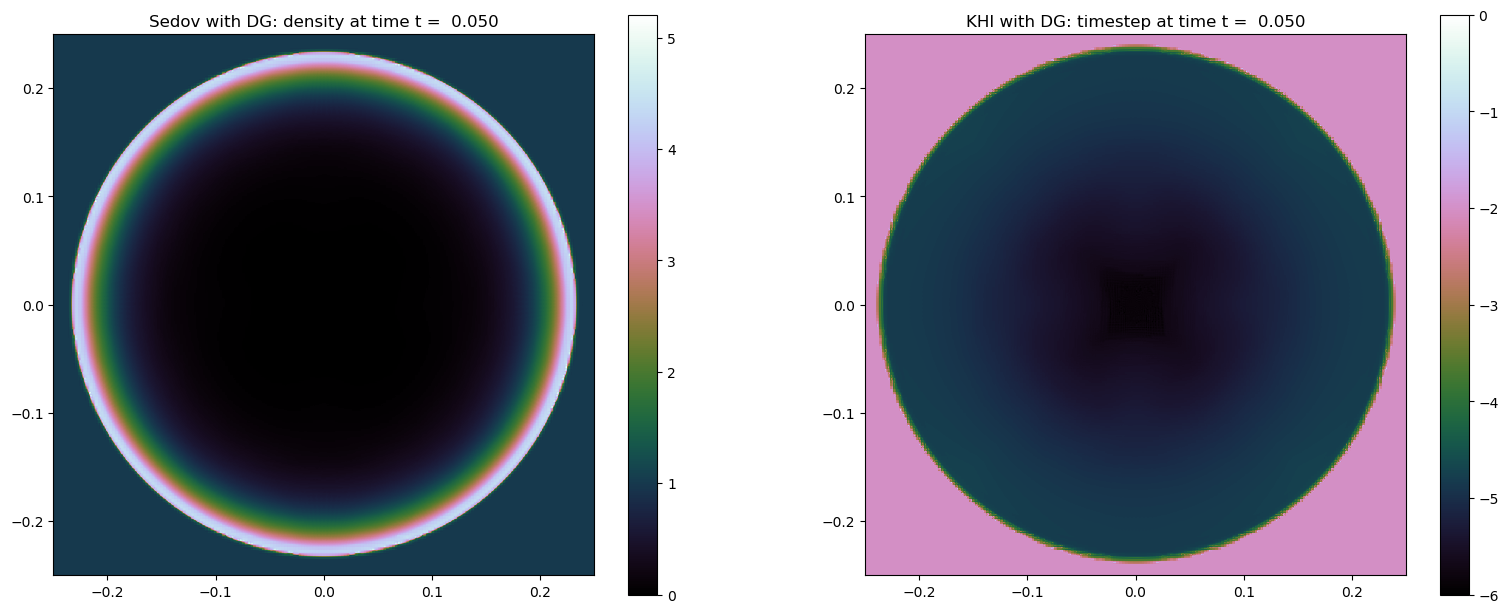

In [131]:
fp = '/mnt/sshfs/cheops/scratch/jmarker2/couchdg/sedov/div-standard-rusanov/data/chkpt_0050.h5'
fh = couchdg.Ribbon(fp)
mkplot(fh,Nvisu=8)

1.30637261016e-05


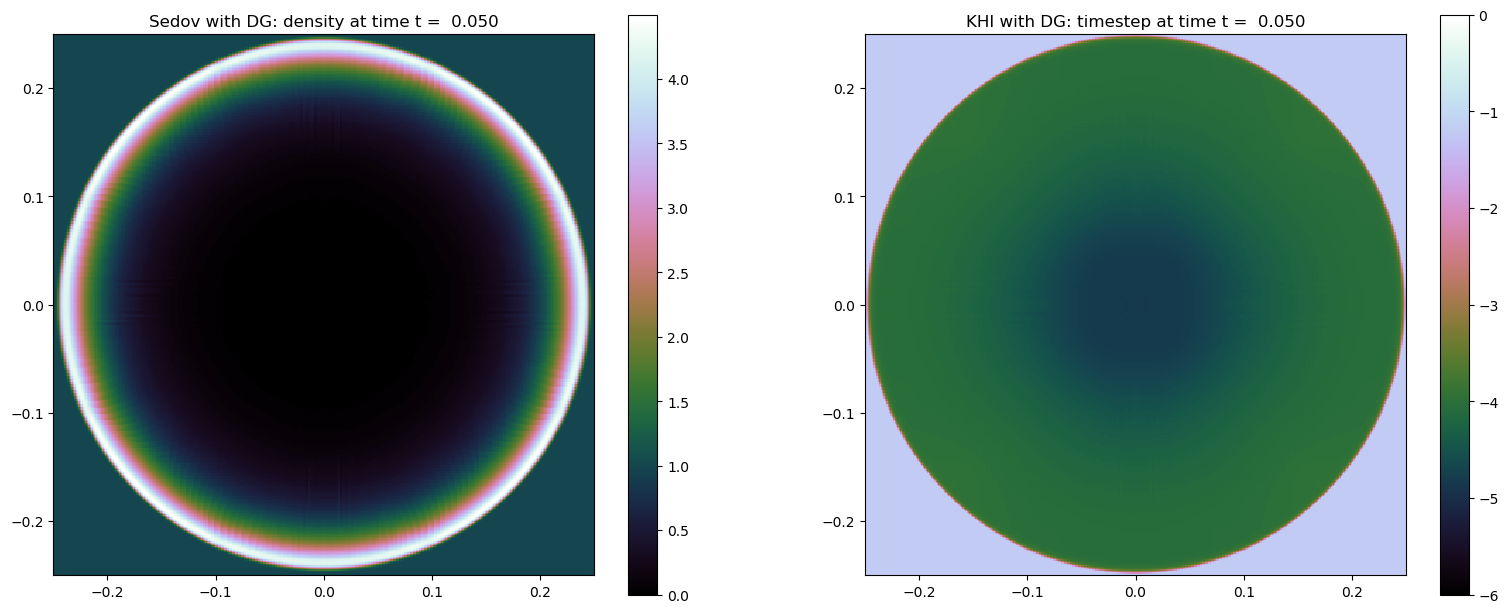

In [133]:
fp = '/mnt/sshfs/cheops/scratch/jmarker2/couchdg/sedov/div-standard-rusanov-ssp/data/chkpt_0050.h5'
fh = couchdg.Ribbon(fp)
mkplot(fh,Nvisu=8)